<a href="https://colab.research.google.com/github/WalnutHo/Web1/blob/main/AI08_lab_ProjectC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI 08 Hymenoptera

> 학번: 2018142089
>
> 이름: 염호윤

---

In [ ]:
# 8.1

import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 8.2

if torch.cuda.is_available():
    device = torch.device('cuda')          
else:
    device = torch.device('cpu')
    
print('device:', device)

device: cuda


### Hyperparameters
---

In [ ]:
# 8.3 하이퍼파라미터

num_epochs = 100
num_classes = 2
batch_size = 8
learning_rate = 0.001

### Load dataset
---

In [ ]:
# 8.5

# Training을 위한 데이터 확장과 데이터셋 정규화

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),  # 랜덤 리사이즈 후 크롭
        transforms.RandomHorizontalFlip(),  # 좌우반전
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Test를 위해서는 데이터셋 정규화만

test_transforms = transforms.Compose([
        transforms.Resize(256),             # 리사이즈
        transforms.CenterCrop(224),         # 가운데 크롭
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [ ]:
# 8.6

# ImageFolder를 사용하여 폴더 안에 있는 이미지들을 데이터셋으로 사용

train_dataset = datasets.ImageFolder( '/content/drive/MyDrive/block_dataset/train', train_transforms)
test_dataset = datasets.ImageFolder( '/content/drive/MyDrive/block_dataset/test', test_transforms)

train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True )

# 분류 클래스 2개: ants, bees

class_names = train_dataset.classes
print(class_names)


['road', 'yellow_blocks']


### Preview data

Preview Dataset


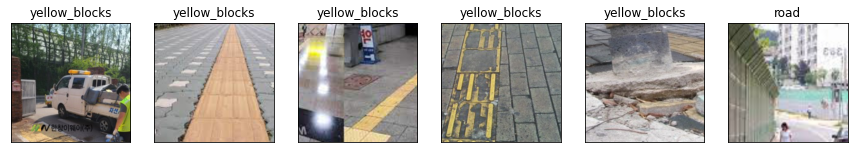

In [ ]:
# 8.7 데이터 미리보기

print("Preview Dataset")
def convert_to_imshow_format(image):
    # from 3 x Height x Width to Height x Width x 3
    image = image.numpy().transpose(1,2,0)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # convert back to [0,1] range from [-1,1] range
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    return image

dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images[:6], labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(15,15))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(class_names[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])    

### Progress monitor
---

In [ ]:
# 8.8

from IPython.display import HTML, display

# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Epoch: {epoch}/{num_epochs} Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0, 0, 0), display_id=True)
        
    def html(self, count, loss, epoch, num_epochs):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss, epoch=epoch, num_epochs=num_epochs))
        
    def update(self, epoch, num_epochs, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss, epoch, num_epochs))

### Finetuning the convnet
___

In [ ]:
# # 8.9 Finetuning the ConvNet

# # 미리 훈련된 Resnet18 가져와서
# model_ft = models.resnet18(pretrained=True)

# # 마지막 fc layer 새로 만들어 out_features를 2로 변경
# model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)

# # 모델을 cuda로 이동
# model_ft = model_ft.to(device)

# # Cross entropy loss 사용
# loss_func = nn.CrossEntropyLoss()

# # Adam
# optimizer_ft = optim.Adam( model_ft.parameters(), lr=0.001 )

# # 매 15 epochs 마다 학습률에 0.1을 곱함
# lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)

In [ ]:
# 8.9 Finetuning the ConvNet

# 미리 훈련된 GoogLeNet 가져와서
model_ft = models.googlenet(pretrained=True)

# 마지막 fc layer 새로 만들어 out_features를 2로 변경
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)

# 모델을 cuda로 이동
model_ft = model_ft.to(device)

# Cross entropy loss 사용
loss_func = nn.CrossEntropyLoss()

# Adam
optimizer_ft = optim.Adam( model_ft.parameters(), lr=0.001 )

# 매 15 epochs 마다 학습률에 0.1을 곱함
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

### Train
---

In [ ]:
# 8.11 Train

def train(epoch, num_epochs, model, optimizer, scheduler):

    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(epoch, num_epochs, batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

    # 스케쥴러의 스텝을 증가 - 때가 되면 학습률 변경
    if scheduler:
        scheduler.step()

        

In [ ]:
# 8.12 Test

def test(model):
    # test phase
    model.eval()

    correct = 0
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  
    
    return acc

In [ ]:
# 8.13

since = time.time()

# initialize the best weights
best_model_weights = copy.deepcopy( model_ft.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # train
    train(epoch+1, num_epochs, model_ft, optimizer_ft, lr_scheduler_ft )
    # test
    acc = test(model_ft)

    # update the best weights
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model_ft.state_dict() )

# load the best weights
model_ft.load_state_dict( best_model_weights )

# summary
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))



Epoch: 1/100 Loss: 0.4173 255 / 255,255


Test Acc: 31/60 (51.67%)


Epoch: 2/100 Loss: 0.3105 255 / 255,255


Test Acc: 51/60 (85.00%)


Epoch: 3/100 Loss: 0.2668 255 / 255,255


Test Acc: 45/60 (75.00%)


Epoch: 4/100 Loss: 0.2733 255 / 255,255


Test Acc: 48/60 (80.00%)


Epoch: 5/100 Loss: 0.2923 255 / 255,255


Test Acc: 45/60 (75.00%)


Epoch: 6/100 Loss: 0.3500 255 / 255,255


Test Acc: 41/60 (68.33%)


Epoch: 7/100 Loss: 0.2382 255 / 255,255


Test Acc: 39/60 (65.00%)


Epoch: 8/100 Loss: 0.2920 255 / 255,255


Test Acc: 46/60 (76.67%)


Epoch: 9/100 Loss: 0.2792 255 / 255,255


Test Acc: 35/60 (58.33%)


Epoch: 10/100 Loss: 0.2293 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 11/100 Loss: 0.3062 255 / 255,255


Test Acc: 42/60 (70.00%)


Epoch: 12/100 Loss: 0.2869 255 / 255,255


Test Acc: 43/60 (71.67%)


Epoch: 13/100 Loss: 0.2327 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 14/100 Loss: 0.2872 255 / 255,255


Test Acc: 33/60 (55.00%)


Epoch: 15/100 Loss: 0.2607 255 / 255,255


Test Acc: 47/60 (78.33%)


Epoch: 16/100 Loss: 0.2353 255 / 255,255


Test Acc: 48/60 (80.00%)


Epoch: 17/100 Loss: 0.2106 255 / 255,255


Test Acc: 43/60 (71.67%)


Epoch: 18/100 Loss: 0.2942 255 / 255,255


Test Acc: 41/60 (68.33%)


Epoch: 19/100 Loss: 0.2279 255 / 255,255


Test Acc: 47/60 (78.33%)


Epoch: 20/100 Loss: 0.2443 255 / 255,255


Test Acc: 38/60 (63.33%)


Epoch: 21/100 Loss: 0.2827 255 / 255,255


Test Acc: 47/60 (78.33%)


Epoch: 22/100 Loss: 0.2036 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 23/100 Loss: 0.2681 255 / 255,255


Test Acc: 49/60 (81.67%)


Epoch: 24/100 Loss: 0.2085 255 / 255,255


Test Acc: 51/60 (85.00%)


Epoch: 25/100 Loss: 0.2086 255 / 255,255


Test Acc: 31/60 (51.67%)


Epoch: 26/100 Loss: 0.2172 255 / 255,255


Test Acc: 47/60 (78.33%)


Epoch: 27/100 Loss: 0.1940 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 28/100 Loss: 0.1856 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 29/100 Loss: 0.1431 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 30/100 Loss: 0.1789 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 31/100 Loss: 0.1823 255 / 255,255


Test Acc: 51/60 (85.00%)


Epoch: 32/100 Loss: 0.1272 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 33/100 Loss: 0.1114 255 / 255,255


Test Acc: 51/60 (85.00%)


Epoch: 34/100 Loss: 0.1539 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 35/100 Loss: 0.1200 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 36/100 Loss: 0.1759 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 37/100 Loss: 0.1479 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 38/100 Loss: 0.1268 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 39/100 Loss: 0.1654 255 / 255,255


Test Acc: 57/60 (95.00%)


Epoch: 40/100 Loss: 0.1195 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 41/100 Loss: 0.1198 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 42/100 Loss: 0.1028 255 / 255,255


Test Acc: 57/60 (95.00%)


Epoch: 43/100 Loss: 0.0837 255 / 255,255


Test Acc: 47/60 (78.33%)


Epoch: 44/100 Loss: 0.1416 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 45/100 Loss: 0.1249 255 / 255,255


Test Acc: 48/60 (80.00%)


Epoch: 46/100 Loss: 0.1268 255 / 255,255


Test Acc: 49/60 (81.67%)


Epoch: 47/100 Loss: 0.0946 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 48/100 Loss: 0.0994 255 / 255,255


Test Acc: 49/60 (81.67%)


Epoch: 49/100 Loss: 0.1356 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 50/100 Loss: 0.1442 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 51/100 Loss: 0.1365 255 / 255,255


Test Acc: 51/60 (85.00%)


Epoch: 52/100 Loss: 0.0917 255 / 255,255


Test Acc: 51/60 (85.00%)


Epoch: 53/100 Loss: 0.1139 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 54/100 Loss: 0.1103 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 55/100 Loss: 0.0574 255 / 255,255


Test Acc: 47/60 (78.33%)


Epoch: 56/100 Loss: 0.0911 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 57/100 Loss: 0.1061 255 / 255,255


Test Acc: 48/60 (80.00%)


Epoch: 58/100 Loss: 0.1530 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 59/100 Loss: 0.0948 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 60/100 Loss: 0.0921 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 61/100 Loss: 0.1051 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 62/100 Loss: 0.0882 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 63/100 Loss: 0.0810 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 64/100 Loss: 0.0978 255 / 255,255


Test Acc: 56/60 (93.33%)


Epoch: 65/100 Loss: 0.1329 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 66/100 Loss: 0.1125 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 67/100 Loss: 0.1036 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 68/100 Loss: 0.0741 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 69/100 Loss: 0.0870 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 70/100 Loss: 0.1069 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 71/100 Loss: 0.1159 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 72/100 Loss: 0.0783 255 / 255,255


Test Acc: 56/60 (93.33%)


Epoch: 73/100 Loss: 0.0921 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 74/100 Loss: 0.1230 255 / 255,255


Test Acc: 57/60 (95.00%)


Epoch: 75/100 Loss: 0.0570 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 76/100 Loss: 0.0988 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 77/100 Loss: 0.0727 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 78/100 Loss: 0.1014 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 79/100 Loss: 0.1023 255 / 255,255


Test Acc: 52/60 (86.67%)


Epoch: 80/100 Loss: 0.0982 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 81/100 Loss: 0.0761 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 82/100 Loss: 0.0862 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 83/100 Loss: 0.0901 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 84/100 Loss: 0.0953 255 / 255,255


Test Acc: 48/60 (80.00%)


Epoch: 85/100 Loss: 0.0770 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 86/100 Loss: 0.0767 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 87/100 Loss: 0.0826 255 / 255,255


Test Acc: 56/60 (93.33%)


Epoch: 88/100 Loss: 0.0755 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 89/100 Loss: 0.0900 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 90/100 Loss: 0.0779 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 91/100 Loss: 0.0937 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 92/100 Loss: 0.0938 255 / 255,255


Test Acc: 55/60 (91.67%)


Epoch: 93/100 Loss: 0.1098 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 94/100 Loss: 0.1336 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 95/100 Loss: 0.0934 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 96/100 Loss: 0.0903 255 / 255,255


Test Acc: 50/60 (83.33%)


Epoch: 97/100 Loss: 0.1172 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 98/100 Loss: 0.0882 255 / 255,255


Test Acc: 53/60 (88.33%)


Epoch: 99/100 Loss: 0.0685 255 / 255,255


Test Acc: 54/60 (90.00%)


Epoch: 100/100 Loss: 0.0847 255 / 255,255


Test Acc: 57/60 (95.00%)
Training completed in 4m 60s
Best test accuracy: 95.000000


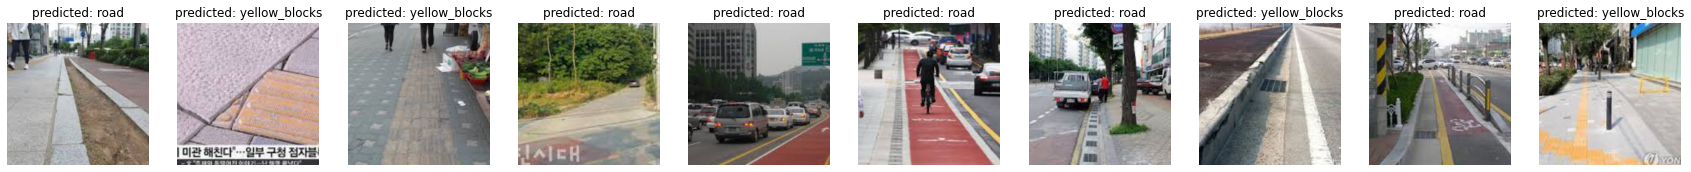

In [ ]:
# 8.14

def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(30,30))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.imshow( convert_to_imshow_format(inputs.cpu().data[j]) )

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

        

visualize_model(model_ft)        